# Fine-tuning SpeechT5 To speak like Andrej Karpathy

This guide demonstrates how to fine-tune the SpeechT5 model to speak just like Andrej Karpathy.
We'll start with a SpeechT5 model that’s already fine-tuned on English and then we’ll fine-tune it with recordings of his voice.

## Install required packages

We install Transformers from GitHub since not all the SpeechT5 features we need have been merged into an official release yet.


In [1]:
#!pip uninstall speechbrain
!pip install git+https://github.com/speechbrain/speechbrain.git


  Cloning https://github.com/speechbrain/speechbrain.git to /tmp/pip-req-build-zlrs7vt5
  Running command git clone --filter=blob:none --quiet https://github.com/speechbrain/speechbrain.git /tmp/pip-req-build-zlrs7vt5
  Resolved https://github.com/speechbrain/speechbrain.git to commit e88b9e8df97fa12400e72b31e49d3405d6a3d163
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x8

In [2]:
!pip install datasets soundfile

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 527.3/527.3 kB 32.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 10.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.9/39.9 MB 52.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 12.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 17.2 MB/s eta 0:00:00
  Attempting uninstall: pyarrow
    Found existing installation: pyarrow 14.0.2
    Uninstalling pyarrow-14.0.2:
      Successfully uninstalled pyarrow-14.0.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf-cu12 24.4.1 requires pyarrow<15.0.0a0,>=14.0.1, but you have pyarrow 17.0.0 which is incompatible.
ibis-framework 8.0.0 requires pyarrow<16,>=2, but you have pyarrow 17.0.0 which is incompatible.


In [3]:
!pip install git+https://github.com/huggingface/transformers.git

  Cloning https://github.com/huggingface/transformers.git to /tmp/pip-req-build-z2cv_w0t
  Running command git clone --filter=blob:none --quiet https://github.com/huggingface/transformers.git /tmp/pip-req-build-z2cv_w0t
  Resolved https://github.com/huggingface/transformers.git to commit 273c0afc8f0289e0cb5d18dc76ccc251504298e0
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for transformers: filename=transformers-4.45.0.dev0-py3-none-any.whl size=9554332 sha256=705266ad103e3d9227338deea6289148c376306892434039dbcc75429a41ff79
  Stored in directory: /tmp/pip-ephem-wheel-cache-f7dsdqzt/wheels/e7/9c/5b/e1a9c8007c343041e61cc484433d512ea9274272e3fcbe7c16
Successfully built transformers
  Attempting uninstall: transformers
    Found existing installation: transformers 4.42.4
    Uninstalling transformers-4.42.4:
      Successfully uninstalled transformers-4.42.4


In [4]:
!pip install --upgrade accelerate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 315.1/315.1 kB 22.7 MB/s eta 0:00:00
  Attempting uninstall: accelerate
    Found existing installation: accelerate 0.32.1
    Uninstalling accelerate-0.32.1:
      Successfully uninstalled accelerate-0.32.1


Do we have a GPU?

In [5]:
!nvidia-smi

Thu Aug 22 17:06:33 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA A100-SXM4-40GB          Off | 00000000:00:04.0 Off |                    0 |
| N/A   30C    P0              43W / 400W |      2MiB / 40960MiB |      0%      Default |
|                                         |                      |             Disabled |
+-----------------------------------------+----------------------+--

In case no GPU is found, from the menu choose **Runtime > Change runtime type** and set **Hardware accelerator** to **GPU**. Then restart the runtime to activate the GPU.

## Load the model

We'll start from SpeechT5 that's already been fine-tuned for English TTS.

In [6]:
from transformers import SpeechT5Processor, SpeechT5ForTextToSpeech

processor = SpeechT5Processor.from_pretrained("microsoft/speecht5_tts")
model = SpeechT5ForTextToSpeech.from_pretrained("microsoft/speecht5_tts")

preprocessor_config.json:   0%|          | 0.00/433 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/232 [00:00<?, ?B/s]

spm_char.model:   0%|          | 0.00/238k [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/40.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/234 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


config.json:   0%|          | 0.00/2.06k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/585M [00:00<?, ?B/s]

## Load the dataset

We'll fine-tune on one of Andrej's youtube videos.

You can find how I built the dataset here: https://github.com/fafadalilian/Youtube_speech_text_dataset_creation

In [7]:
from datasets import load_dataset, Audio
trans_data=load_dataset( "Fafadalilian/Andrej_Karpathy_voice_transcription1")

Generating train split:   0%|          | 0/169 [00:00<?, ? examples/s]

In [8]:
from huggingface_hub import snapshot_download

# Define the repository ID, e.g., "Fafadalilian/Andrej_Karpathy_voice"
dataset_repo = "Fafadalilian/Andrej_Karpathy_voice_transcription1"

# Specify the local directory where you want to save the files
data_dir = "./data_dir"

# Download the files from the Hugging Face repository
file_path = snapshot_download(repo_id=dataset_repo, local_dir=data_dir, repo_type="dataset")

# Print the path to the downloaded files
print(f"Files downloaded to: {file_path}")

Fetching 172 files:   0%|          | 0/172 [00:00<?, ?it/s]

.gitattributes:   0%|          | 0.00/2.42k [00:00<?, ?B/s]

train_list.txt:   0%|          | 0.00/33.7k [00:00<?, ?B/s]

output.txt:   0%|          | 0.00/33.7k [00:00<?, ?B/s]

llm_intro_0.wav:   0%|          | 0.00/1.60M [00:00<?, ?B/s]

llm_intro_101.wav:   0%|          | 0.00/2.12M [00:00<?, ?B/s]

llm_intro_100.wav:   0%|          | 0.00/1.54M [00:00<?, ?B/s]

llm_intro_1.wav:   0%|          | 0.00/2.06M [00:00<?, ?B/s]

llm_intro_10.wav:   0%|          | 0.00/1.51M [00:00<?, ?B/s]

llm_intro_102.wav:   0%|          | 0.00/1.70M [00:00<?, ?B/s]

llm_intro_103.wav:   0%|          | 0.00/1.41M [00:00<?, ?B/s]

llm_intro_104.wav:   0%|          | 0.00/2.07M [00:00<?, ?B/s]

llm_intro_106.wav:   0%|          | 0.00/1.30M [00:00<?, ?B/s]

llm_intro_107.wav:   0%|          | 0.00/2.04M [00:00<?, ?B/s]

llm_intro_105.wav:   0%|          | 0.00/1.68M [00:00<?, ?B/s]

llm_intro_108.wav:   0%|          | 0.00/1.87M [00:00<?, ?B/s]

llm_intro_109.wav:   0%|          | 0.00/1.57M [00:00<?, ?B/s]

llm_intro_110.wav:   0%|          | 0.00/1.87M [00:00<?, ?B/s]

llm_intro_112.wav:   0%|          | 0.00/1.82M [00:00<?, ?B/s]

llm_intro_11.wav:   0%|          | 0.00/2.05M [00:00<?, ?B/s]

llm_intro_111.wav:   0%|          | 0.00/1.58M [00:00<?, ?B/s]

llm_intro_114.wav:   0%|          | 0.00/1.94M [00:00<?, ?B/s]

llm_intro_113.wav:   0%|          | 0.00/2.10M [00:00<?, ?B/s]

llm_intro_115.wav:   0%|          | 0.00/1.84M [00:00<?, ?B/s]

llm_intro_116.wav:   0%|          | 0.00/2.17M [00:00<?, ?B/s]

llm_intro_117.wav:   0%|          | 0.00/1.73M [00:00<?, ?B/s]

llm_intro_118.wav:   0%|          | 0.00/1.91M [00:00<?, ?B/s]

llm_intro_12.wav:   0%|          | 0.00/1.91M [00:00<?, ?B/s]

llm_intro_120.wav:   0%|          | 0.00/2.24M [00:00<?, ?B/s]

llm_intro_121.wav:   0%|          | 0.00/2.01M [00:00<?, ?B/s]

llm_intro_119.wav:   0%|          | 0.00/1.84M [00:00<?, ?B/s]

llm_intro_124.wav:   0%|          | 0.00/2.23M [00:00<?, ?B/s]

llm_intro_123.wav:   0%|          | 0.00/1.60M [00:00<?, ?B/s]

llm_intro_122.wav:   0%|          | 0.00/1.64M [00:00<?, ?B/s]

llm_intro_125.wav:   0%|          | 0.00/2.11M [00:00<?, ?B/s]

llm_intro_126.wav:   0%|          | 0.00/2.17M [00:00<?, ?B/s]

llm_intro_127.wav:   0%|          | 0.00/2.14M [00:00<?, ?B/s]

llm_intro_129.wav:   0%|          | 0.00/1.98M [00:00<?, ?B/s]

llm_intro_13.wav:   0%|          | 0.00/1.76M [00:00<?, ?B/s]

llm_intro_128.wav:   0%|          | 0.00/1.66M [00:00<?, ?B/s]

llm_intro_130.wav:   0%|          | 0.00/1.84M [00:00<?, ?B/s]

llm_intro_131.wav:   0%|          | 0.00/1.92M [00:00<?, ?B/s]

llm_intro_132.wav:   0%|          | 0.00/1.54M [00:00<?, ?B/s]

llm_intro_133.wav:   0%|          | 0.00/1.78M [00:00<?, ?B/s]

llm_intro_134.wav:   0%|          | 0.00/1.45M [00:00<?, ?B/s]

llm_intro_135.wav:   0%|          | 0.00/2.02M [00:00<?, ?B/s]

llm_intro_136.wav:   0%|          | 0.00/1.75M [00:00<?, ?B/s]

llm_intro_138.wav:   0%|          | 0.00/1.71M [00:00<?, ?B/s]

llm_intro_137.wav:   0%|          | 0.00/2.32M [00:00<?, ?B/s]

llm_intro_139.wav:   0%|          | 0.00/2.76M [00:00<?, ?B/s]

llm_intro_14.wav:   0%|          | 0.00/1.98M [00:00<?, ?B/s]

llm_intro_140.wav:   0%|          | 0.00/1.98M [00:00<?, ?B/s]

llm_intro_141.wav:   0%|          | 0.00/1.80M [00:00<?, ?B/s]

llm_intro_142.wav:   0%|          | 0.00/1.73M [00:00<?, ?B/s]

llm_intro_143.wav:   0%|          | 0.00/2.12M [00:00<?, ?B/s]

llm_intro_144.wav:   0%|          | 0.00/2.00M [00:00<?, ?B/s]

llm_intro_145.wav:   0%|          | 0.00/1.90M [00:00<?, ?B/s]

llm_intro_146.wav:   0%|          | 0.00/1.97M [00:00<?, ?B/s]

llm_intro_147.wav:   0%|          | 0.00/2.16M [00:00<?, ?B/s]

llm_intro_149.wav:   0%|          | 0.00/1.64M [00:00<?, ?B/s]

llm_intro_15.wav:   0%|          | 0.00/2.01M [00:00<?, ?B/s]

llm_intro_150.wav:   0%|          | 0.00/1.68M [00:00<?, ?B/s]

llm_intro_151.wav:   0%|          | 0.00/2.31M [00:00<?, ?B/s]

llm_intro_148.wav:   0%|          | 0.00/1.58M [00:00<?, ?B/s]

llm_intro_154.wav:   0%|          | 0.00/2.39M [00:00<?, ?B/s]

llm_intro_152.wav:   0%|          | 0.00/2.13M [00:00<?, ?B/s]

llm_intro_153.wav:   0%|          | 0.00/2.11M [00:00<?, ?B/s]

llm_intro_155.wav:   0%|          | 0.00/2.32M [00:00<?, ?B/s]

llm_intro_156.wav:   0%|          | 0.00/1.91M [00:00<?, ?B/s]

llm_intro_159.wav:   0%|          | 0.00/1.55M [00:00<?, ?B/s]

llm_intro_158.wav:   0%|          | 0.00/2.21M [00:00<?, ?B/s]

llm_intro_157.wav:   0%|          | 0.00/1.60M [00:00<?, ?B/s]

llm_intro_160.wav:   0%|          | 0.00/2.21M [00:00<?, ?B/s]

llm_intro_16.wav:   0%|          | 0.00/1.71M [00:00<?, ?B/s]

llm_intro_161.wav:   0%|          | 0.00/2.30M [00:00<?, ?B/s]

llm_intro_162.wav:   0%|          | 0.00/1.85M [00:00<?, ?B/s]

llm_intro_163.wav:   0%|          | 0.00/1.50M [00:00<?, ?B/s]

llm_intro_165.wav:   0%|          | 0.00/1.93M [00:00<?, ?B/s]

llm_intro_164.wav:   0%|          | 0.00/2.42M [00:00<?, ?B/s]

llm_intro_166.wav:   0%|          | 0.00/1.98M [00:00<?, ?B/s]

llm_intro_167.wav:   0%|          | 0.00/1.78M [00:00<?, ?B/s]

llm_intro_168.wav:   0%|          | 0.00/1.70M [00:00<?, ?B/s]

llm_intro_17.wav:   0%|          | 0.00/2.12M [00:00<?, ?B/s]

llm_intro_18.wav:   0%|          | 0.00/1.63M [00:00<?, ?B/s]

llm_intro_19.wav:   0%|          | 0.00/1.82M [00:00<?, ?B/s]

llm_intro_2.wav:   0%|          | 0.00/2.13M [00:00<?, ?B/s]

llm_intro_20.wav:   0%|          | 0.00/2.33M [00:00<?, ?B/s]

llm_intro_21.wav:   0%|          | 0.00/1.78M [00:00<?, ?B/s]

llm_intro_22.wav:   0%|          | 0.00/2.12M [00:00<?, ?B/s]

llm_intro_23.wav:   0%|          | 0.00/1.65M [00:00<?, ?B/s]

llm_intro_24.wav:   0%|          | 0.00/2.26M [00:00<?, ?B/s]

llm_intro_26.wav:   0%|          | 0.00/1.56M [00:00<?, ?B/s]

llm_intro_27.wav:   0%|          | 0.00/1.38M [00:00<?, ?B/s]

llm_intro_28.wav:   0%|          | 0.00/1.79M [00:00<?, ?B/s]

llm_intro_29.wav:   0%|          | 0.00/1.94M [00:00<?, ?B/s]

llm_intro_3.wav:   0%|          | 0.00/1.91M [00:00<?, ?B/s]

llm_intro_30.wav:   0%|          | 0.00/1.86M [00:00<?, ?B/s]

llm_intro_25.wav:   0%|          | 0.00/1.64M [00:00<?, ?B/s]

llm_intro_32.wav:   0%|          | 0.00/1.58M [00:00<?, ?B/s]

llm_intro_31.wav:   0%|          | 0.00/1.55M [00:00<?, ?B/s]

llm_intro_34.wav:   0%|          | 0.00/2.02M [00:00<?, ?B/s]

llm_intro_33.wav:   0%|          | 0.00/1.85M [00:00<?, ?B/s]

llm_intro_36.wav:   0%|          | 0.00/1.40M [00:00<?, ?B/s]

llm_intro_35.wav:   0%|          | 0.00/2.03M [00:00<?, ?B/s]

llm_intro_37.wav:   0%|          | 0.00/1.88M [00:00<?, ?B/s]

llm_intro_38.wav:   0%|          | 0.00/1.50M [00:00<?, ?B/s]

llm_intro_39.wav:   0%|          | 0.00/1.34M [00:00<?, ?B/s]

llm_intro_40.wav:   0%|          | 0.00/1.77M [00:00<?, ?B/s]

llm_intro_4.wav:   0%|          | 0.00/1.92M [00:00<?, ?B/s]

llm_intro_41.wav:   0%|          | 0.00/2.18M [00:00<?, ?B/s]

llm_intro_42.wav:   0%|          | 0.00/1.52M [00:00<?, ?B/s]

llm_intro_43.wav:   0%|          | 0.00/1.79M [00:00<?, ?B/s]

llm_intro_44.wav:   0%|          | 0.00/1.81M [00:00<?, ?B/s]

llm_intro_45.wav:   0%|          | 0.00/1.84M [00:00<?, ?B/s]

llm_intro_46.wav:   0%|          | 0.00/2.40M [00:00<?, ?B/s]

llm_intro_47.wav:   0%|          | 0.00/1.64M [00:00<?, ?B/s]

llm_intro_48.wav:   0%|          | 0.00/2.33M [00:00<?, ?B/s]

llm_intro_49.wav:   0%|          | 0.00/1.71M [00:00<?, ?B/s]

llm_intro_5.wav:   0%|          | 0.00/1.76M [00:00<?, ?B/s]

llm_intro_50.wav:   0%|          | 0.00/1.46M [00:00<?, ?B/s]

llm_intro_51.wav:   0%|          | 0.00/2.02M [00:00<?, ?B/s]

llm_intro_52.wav:   0%|          | 0.00/2.06M [00:00<?, ?B/s]

llm_intro_53.wav:   0%|          | 0.00/2.22M [00:00<?, ?B/s]

llm_intro_54.wav:   0%|          | 0.00/2.06M [00:00<?, ?B/s]

llm_intro_55.wav:   0%|          | 0.00/1.34M [00:00<?, ?B/s]

llm_intro_56.wav:   0%|          | 0.00/1.94M [00:00<?, ?B/s]

llm_intro_57.wav:   0%|          | 0.00/2.21M [00:00<?, ?B/s]

llm_intro_58.wav:   0%|          | 0.00/1.74M [00:00<?, ?B/s]

llm_intro_59.wav:   0%|          | 0.00/1.58M [00:00<?, ?B/s]

llm_intro_6.wav:   0%|          | 0.00/2.00M [00:00<?, ?B/s]

llm_intro_60.wav:   0%|          | 0.00/1.39M [00:00<?, ?B/s]

llm_intro_61.wav:   0%|          | 0.00/1.77M [00:00<?, ?B/s]

llm_intro_62.wav:   0%|          | 0.00/2.15M [00:00<?, ?B/s]

llm_intro_63.wav:   0%|          | 0.00/1.83M [00:00<?, ?B/s]

llm_intro_64.wav:   0%|          | 0.00/1.63M [00:00<?, ?B/s]

llm_intro_65.wav:   0%|          | 0.00/1.61M [00:00<?, ?B/s]

llm_intro_66.wav:   0%|          | 0.00/1.60M [00:00<?, ?B/s]

llm_intro_67.wav:   0%|          | 0.00/1.81M [00:00<?, ?B/s]

llm_intro_68.wav:   0%|          | 0.00/1.37M [00:00<?, ?B/s]

llm_intro_69.wav:   0%|          | 0.00/2.20M [00:00<?, ?B/s]

llm_intro_7.wav:   0%|          | 0.00/2.05M [00:00<?, ?B/s]

llm_intro_70.wav:   0%|          | 0.00/1.61M [00:00<?, ?B/s]

llm_intro_71.wav:   0%|          | 0.00/1.94M [00:00<?, ?B/s]

llm_intro_72.wav:   0%|          | 0.00/2.12M [00:00<?, ?B/s]

llm_intro_73.wav:   0%|          | 0.00/1.66M [00:00<?, ?B/s]

llm_intro_75.wav:   0%|          | 0.00/1.91M [00:00<?, ?B/s]

llm_intro_76.wav:   0%|          | 0.00/1.52M [00:00<?, ?B/s]

llm_intro_77.wav:   0%|          | 0.00/1.74M [00:00<?, ?B/s]

llm_intro_79.wav:   0%|          | 0.00/1.72M [00:00<?, ?B/s]

llm_intro_78.wav:   0%|          | 0.00/2.03M [00:00<?, ?B/s]

llm_intro_8.wav:   0%|          | 0.00/1.63M [00:00<?, ?B/s]

llm_intro_74.wav:   0%|          | 0.00/1.62M [00:00<?, ?B/s]

llm_intro_81.wav:   0%|          | 0.00/1.92M [00:00<?, ?B/s]

llm_intro_80.wav:   0%|          | 0.00/1.78M [00:00<?, ?B/s]

llm_intro_82.wav:   0%|          | 0.00/2.30M [00:00<?, ?B/s]

llm_intro_83.wav:   0%|          | 0.00/1.40M [00:00<?, ?B/s]

llm_intro_85.wav:   0%|          | 0.00/2.02M [00:00<?, ?B/s]

llm_intro_84.wav:   0%|          | 0.00/1.65M [00:00<?, ?B/s]

llm_intro_86.wav:   0%|          | 0.00/2.04M [00:00<?, ?B/s]

llm_intro_87.wav:   0%|          | 0.00/2.67M [00:00<?, ?B/s]

llm_intro_88.wav:   0%|          | 0.00/2.43M [00:00<?, ?B/s]

llm_intro_89.wav:   0%|          | 0.00/1.64M [00:00<?, ?B/s]

llm_intro_9.wav:   0%|          | 0.00/2.01M [00:00<?, ?B/s]

llm_intro_91.wav:   0%|          | 0.00/2.15M [00:00<?, ?B/s]

llm_intro_90.wav:   0%|          | 0.00/1.51M [00:00<?, ?B/s]

llm_intro_92.wav:   0%|          | 0.00/1.71M [00:00<?, ?B/s]

llm_intro_93.wav:   0%|          | 0.00/1.94M [00:00<?, ?B/s]

llm_intro_94.wav:   0%|          | 0.00/2.59M [00:00<?, ?B/s]

llm_intro_96.wav:   0%|          | 0.00/1.69M [00:00<?, ?B/s]

llm_intro_95.wav:   0%|          | 0.00/1.56M [00:00<?, ?B/s]

llm_intro_97.wav:   0%|          | 0.00/1.87M [00:00<?, ?B/s]

llm_intro_98.wav:   0%|          | 0.00/1.65M [00:00<?, ?B/s]

llm_intro_99.wav:   0%|          | 0.00/1.94M [00:00<?, ?B/s]

Files downloaded to: /content/data_dir


In [9]:
trans_data

DatasetDict({
    train: Dataset({
        features: ['text'],
        num_rows: 169
    })
})

In [10]:
"""for example in trans_data['train']:
    # Split the text field to get the filename and transcription
    text_split = example['text'].split('|')"""

"for example in trans_data['train']:\n    # Split the text field to get the filename and transcription\n    text_split = example['text'].split('|')"

It's important to set the sampling rate of the audio data to 16 kHz, which is what SpeechT5 expects.

In [12]:
import os
import librosa
from datasets import Dataset, Audio

# Define the directory where the WAV files are stored
wav_folder = "./data_dir/wavs"

# Define the target sampling rate
target_sampling_rate = 16000

# Initialize the data structure
data = {
    "audio_id": [],
    "audio": [],
    "raw_text": [],
    "normalized_text": [],
    "language": [],
    "gender": [],
    "speaker_id": [],
    "is_gold_transcript": [],
    "accent": []
}

# Iterate over the examples in the dataset
for example in trans_data['train']:
    # Split the text field to get the filename and transcription
    text_split = example['text'].split('|')
    if len(text_split) == 3:
        wav_filename, transcription, _ = text_split

        # Add to data structure
        data["audio_id"].append(wav_filename)

        # Load the WAV file
        wav_path = os.path.join(wav_folder, wav_filename)
        if os.path.exists(wav_path):
            try:
                # Load the audio file
                audio_data, sr = librosa.load(wav_path, sr=None)

                # Resample the audio data if necessary
                if sr != target_sampling_rate:
                    audio_data = librosa.resample(audio_data, orig_sr=sr, target_sr=target_sampling_rate)
                    sr = target_sampling_rate

                print(f"Loaded and resampled WAV file: {wav_path}")
                data["audio"].append({"array": audio_data, "sampling_rate": sr})
            except Exception as e:
                print(f"Error loading or resampling WAV file {wav_path}: {e}")
                data["audio"].append(None)  # Handle errors in loading or resampling audio
        else:
            print(f"WAV file not found: {wav_path}")
            data["audio"].append(None)  # Handle missing files

        data["raw_text"].append(transcription)
        data["normalized_text"].append(transcription)  # Placeholder for actual normalization
        data["language"].append("en")  # Placeholder for actual language data
        data["gender"].append("unknown")  # Placeholder for actual gender data
        data["speaker_id"].append("unknown_speaker")  # Placeholder for actual speaker ID
        data["is_gold_transcript"].append(False)  # Placeholder for actual transcript quality
        data["accent"].append("unknown")  # Placeholder for actual accent data

# Convert to Hugging Face Dataset
dataset = Dataset.from_dict(data)

# Cast the 'audio' column to the Audio feature type
dataset = dataset.cast_column("audio", Audio())

# Inspect the created dataset
print(dataset)


Loaded and resampled WAV file: ./data_dir/wavs/llm_intro_0.wav
Loaded and resampled WAV file: ./data_dir/wavs/llm_intro_1.wav
Loaded and resampled WAV file: ./data_dir/wavs/llm_intro_2.wav
Loaded and resampled WAV file: ./data_dir/wavs/llm_intro_3.wav
Loaded and resampled WAV file: ./data_dir/wavs/llm_intro_4.wav
Loaded and resampled WAV file: ./data_dir/wavs/llm_intro_5.wav
Loaded and resampled WAV file: ./data_dir/wavs/llm_intro_6.wav
Loaded and resampled WAV file: ./data_dir/wavs/llm_intro_7.wav
Loaded and resampled WAV file: ./data_dir/wavs/llm_intro_8.wav
Loaded and resampled WAV file: ./data_dir/wavs/llm_intro_9.wav
Loaded and resampled WAV file: ./data_dir/wavs/llm_intro_10.wav
Loaded and resampled WAV file: ./data_dir/wavs/llm_intro_11.wav
Loaded and resampled WAV file: ./data_dir/wavs/llm_intro_12.wav
Loaded and resampled WAV file: ./data_dir/wavs/llm_intro_13.wav
Loaded and resampled WAV file: ./data_dir/wavs/llm_intro_14.wav
Loaded and resampled WAV file: ./data_dir/wavs/llm

In [13]:
example=dataset[0]

In [14]:
example

{'audio_id': 'llm_intro_0.wav',
 'audio': {'path': None,
  'array': array([-0.00091553, -0.00158691, -0.00131226, ..., -0.00231934,
         -0.00192261, -0.00210571]),
  'sampling_rate': 16000},
 'raw_text': "This is unlike many other language models that you might be familiar with. For example, if you're using Chats GPT or something like that, the model architecture was never released.",
 'normalized_text': "This is unlike many other language models that you might be familiar with. For example, if you're using Chats GPT or something like that, the model architecture was never released.",
 'language': 'en',
 'gender': 'unknown',
 'speaker_id': 'unknown_speaker',
 'is_gold_transcript': False,
 'accent': 'unknown'}

In [15]:
textt=example['raw_text']

In [16]:
textt


"This is unlike many other language models that you might be familiar with. For example, if you're using Chats GPT or something like that, the model architecture was never released."

In [17]:
# Play the audio
audio_ex = example["audio"]
from IPython.display import Audio

# Play the audio
Audio(audio_ex['array'], rate=audio_ex['sampling_rate'])


In [18]:
print(dataset['audio'][0])

{'path': None, 'array': array([-0.00091553, -0.00158691, -0.00131226, ..., -0.00231934,
       -0.00192261, -0.00210571]), 'sampling_rate': 16000}


## Clean up the text

The dataset may contain characters that are not in the SpeechT5 tokenizer vocabulary like mathematic numbers: 1, 2, 3, etc.



First we'll need to find out what the unsupported tokens are. The `SpeechT5Tokenizer` works with characters as tokens, so let's extract all distinct characters of the dataset. We write a mapping function `extract_all_chars` that concatenates the transcriptions from all examples into one long transcription and then transforms the string into a set of characters. It is important to pass the arguments `batched=True` and `batch_size=-1` to `dataset.map(...)` so that the mapping function has access to all transcriptions at once.

In [19]:
tokenizer = processor.tokenizer

In [21]:
def extract_all_chars(batch):
    all_text = " ".join(batch["normalized_text"])
    vocab = list(set(all_text))
    return {"vocab": [vocab], "all_text": [all_text]}

vocabs = dataset.map(
    extract_all_chars,
    batched=True,
    batch_size=-1,
    keep_in_memory=True,
    remove_columns=dataset.column_names,
)

dataset_vocab = set(vocabs["vocab"][0])
tokenizer_vocab = {k for k,_ in tokenizer.get_vocab().items()}

Map:   0%|          | 0/169 [00:00<?, ? examples/s]

Now we have two sets of characters, one with the vocabulary from the dataset and one with the vocabulary from the tokenizer. By taking the difference between these sets, we find the characters that are in the dataset but not in the tokenizer.

In [26]:
dataset_vocab - tokenizer_vocab

{' ', '$', '%', '&', '0', '1', '2', '3', '4', '5', '6', '7', '9'}

Next, we will define a function to map these characters to valid tokens and then run it on the dataset. No need to handle space, that's already replaced by `▁` in the tokenizer.

In [27]:
replacements = [
    ('&', 'and'),
    ('$', 'dollar'),
    ('%', 'percent'),
    ("1", "one"),
    ("2", "two"),
    ("3", "three"),
    ("4", "four"),
    ("5", "five"),
    ("6", "six"),
     ("7", "seven"),
    ("8", "eight"),
    ("9", "nine"),
    ("0", "zero"),
]

def cleanup_text(inputs):
    for src, dst in replacements:
        inputs["normalized_text"] = inputs["normalized_text"].replace(src, dst)
    return inputs

dataset = dataset.map(cleanup_text)

Map:   0%|          | 0/169 [00:00<?, ? examples/s]

In [28]:
example=dataset[0]

## Speaker embeddings

To allow the TTS model to distinguish between multiple speakers, we'll need to create a speaker embedding for each example. The speaker embedding is simply an additional input into the model that captures a particular speaker's voice characteristics.

To create the speaker embeddings, we use the [spkrec-xvect-voxceleb](https://huggingface.co/speechbrain/spkrec-xvect-voxceleb) model from SpeechBrain. The following defines a function `create_speaker_embedding()` that takes an input audio waveform and outputs a 512-element vector containing the corresponding speaker embedding.

In [35]:
import speechbrain

['__doc__', '__loader__', '__name__', '__package__', '__spec__', 'extra_reason', 'lazy_module', 'old_import', 'package', 'target']


In [36]:
import os
import torch
from speechbrain.pretrained import EncoderClassifier

spk_model_name = "speechbrain/spkrec-xvect-voxceleb"

device = "cuda" if torch.cuda.is_available() else "cpu"
speaker_model = EncoderClassifier.from_hparams(
    source=spk_model_name,
    run_opts={"device": device},
    savedir=os.path.join("/tmp", spk_model_name)
)

def create_speaker_embedding(waveform):
    with torch.no_grad():
        speaker_embeddings = speaker_model.encode_batch(torch.tensor(waveform))
        speaker_embeddings = torch.nn.functional.normalize(speaker_embeddings, dim=2)
        speaker_embeddings = speaker_embeddings.squeeze().cpu().numpy()
    return speaker_embeddings

<ipython-input-36-9f95de381175>:3: UserWarning: Module 'speechbrain.pretrained' was deprecated, redirecting to 'speechbrain.inference'. Please update your script. This is a change from SpeechBrain 1.0. See: https://github.com/speechbrain/speechbrain/releases/tag/v1.0.0
  from speechbrain.pretrained import EncoderClassifier


hyperparams.yaml:   0%|          | 0.00/2.04k [00:00<?, ?B/s]

embedding_model.ckpt:   0%|          | 0.00/16.9M [00:00<?, ?B/s]

mean_var_norm_emb.ckpt:   0%|          | 0.00/3.20k [00:00<?, ?B/s]

classifier.ckpt:   0%|          | 0.00/15.9M [00:00<?, ?B/s]

label_encoder.txt:   0%|          | 0.00/129k [00:00<?, ?B/s]

In [37]:
example_p = processor(
        text=example["normalized_text"],
        audio_target=example ["audio"]["array"],
        sampling_rate=example["audio"]["sampling_rate"],
        return_attention_mask=False,
    )

In [38]:
example_p

{'input_ids': [4, 32, 11, 10, 12, 4, 10, 12, 4, 16, 9, 15, 10, 28, 5, 4, 18, 7, 9, 22, 4, 8, 6, 11, 5, 13, 4, 15, 7, 9, 21, 16, 7, 21, 5, 4, 18, 8, 14, 5, 15, 12, 4, 6, 11, 7, 6, 4, 22, 8, 16, 4, 18, 10, 21, 11, 6, 4, 25, 5, 4, 19, 7, 18, 10, 15, 10, 7, 13, 4, 20, 10, 6, 11, 26, 4, 55, 8, 13, 4, 5, 37, 7, 18, 24, 15, 5, 23, 4, 10, 19, 4, 22, 8, 16, 31, 13, 5, 4, 16, 12, 10, 9, 21, 4, 42, 11, 7, 6, 12, 4, 53, 49, 32, 4, 8, 13, 4, 12, 8, 18, 5, 6, 11, 10, 9, 21, 4, 15, 10, 28, 5, 4, 6, 11, 7, 6, 23, 4, 6, 11, 5, 4, 18, 8, 14, 5, 15, 4, 7, 13, 17, 11, 10, 6, 5, 17, 6, 16, 13, 5, 4, 20, 7, 12, 4, 9, 5, 27, 5, 13, 4, 13, 5, 15, 5, 7, 12, 5, 14, 26, 2], 'labels': array([[[-2.0392807, -2.6622102, -2.9365225, ..., -4.3093486,
         -4.359005 , -4.2241764],
        [-2.072862 , -2.5136864, -2.9083762, ..., -4.3830047,
         -4.3674564, -4.3254266],
        [-2.1033726, -2.4316561, -2.6167943, ..., -4.418811 ,
         -4.3876996, -4.353113 ],
        ...,
        [-2.1324565, -2.3659034, 

In [39]:
example_p.keys()

dict_keys(['input_ids', 'labels'])

## Preparing the dataset

The `prepare_dataset` function takes in a single example and uses the `SpeechT5Processor` object to tokenize the input text and load the target audio into a log-mel spectrogram. It also adds the speaker embeddings as an additional input.

In [40]:
def prepare_dataset(example):
    # load the audio data; if necessary, this resamples the audio to 16kHz
    audio = example["audio"]

    # feature extraction and tokenization
    example = processor(
        text=example["normalized_text"],
        audio_target=audio["array"],
        sampling_rate=audio["sampling_rate"],
        return_attention_mask=False,
    )

    # strip off the batch dimension
    example["labels"] = example["labels"][0]

    # use SpeechBrain to obtain x-vector
    example["speaker_embeddings"] = create_speaker_embedding(audio["array"])

    return example

Let's verify the processing is correct by looking at a single example:

In [41]:
processed_example = prepare_dataset(dataset[0])

This should give us:

- the tokens for the input text in `input_ids`
- the speaker embedding in `speaker_embeddings`
- the target spectrogram in `labels`

In [42]:
processed_example.keys()

dict_keys(['input_ids', 'labels', 'speaker_embeddings'])

In [45]:
tokenizer.decode(processed_example["input_ids"])

"This is unlike many other language models that you might be familiar with. For example, if you're using Chats GPT or something like that, the model architecture was never released.</s>"

Speaker embeddings should be a 512-element vector:

In [46]:
processed_example["speaker_embeddings"].shape

(512,)

In [47]:
processed_example["labels"].shape

(523, 80)

In [48]:
processed_example.keys()

dict_keys(['input_ids', 'labels', 'speaker_embeddings'])

The labels should be a log-mel spectrogram with 80 mel bins.

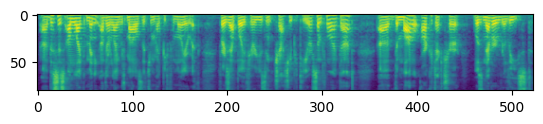

In [49]:
import matplotlib.pyplot as plt
plt.figure()
plt.imshow(processed_example["labels"].T)
plt.show()

If we run a vocoder on the log-mel spectrogram, it should produce the original audio again. We'll load the HiFi-GAN vocoder from the original [SpeechT5 checkpoint](https://hf.co/microsoft/speecht5_hifigan).

In [50]:
from transformers import SpeechT5HifiGan
vocoder = SpeechT5HifiGan.from_pretrained("microsoft/speecht5_hifigan")

config.json:   0%|          | 0.00/636 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/50.7M [00:00<?, ?B/s]

In [51]:
spectrogram = torch.tensor(processed_example["labels"])
with torch.no_grad():
    speech = vocoder(spectrogram)

In [52]:
from IPython.display import Audio
Audio(speech.cpu().numpy(), rate=16000)

In [53]:
len(tokenizer.decode(processed_example["input_ids"]))

184

That all looks and sounds good! We can now process the entire dataset.

In [54]:
labeled_dataset = dataset.map(
    prepare_dataset, remove_columns=dataset.column_names,
)

Map:   0%|          | 0/169 [00:00<?, ? examples/s]

In [55]:
for example in labeled_dataset:
  print(len(example["input_ids"]))

182
177
183
199
202
207
164
178
165
203
168
182
206
175
190
203
180
198
181
179
202
184
194
162
183
175
163
170
172
196
198
164
183
192
184
180
164
201
181
171
170
198
166
175
175
170
174
163
186
176
166
173
202
194
196
180
198
201
198
187
172
176
191
174
170
188
173
186
174
194
177
189
184
175
165
187
173
194
170
165
165
194
186
163
165
203
173
215
194
179
167
190
171
169
202
172
199
195
179
187
202
183
198
170
181
202
168
202
197
167
192
172
168
178
195
198
204
194
183
166
198
198
181
167
202
187
194
202
168
176
174
179
187
164
169
202
177
196
176
173
201
170
175
188
202
182
201
202
172
185
187
190
184
182
200
177
190
180
199
177
178
198
170
174
200
168
201
188
170


Some of the examples in the dataset are apparently longer than the maximum input length the model can handle (600 tokens), so we should remove those from the dataset. In fact, to allow for larger batch sizes we'll remove anything over 200 tokens.

In [56]:
def is_not_too_long(input_ids):
    input_length = len(input_ids)
    return input_length < 200

filt_dataset = labeled_dataset.filter(is_not_too_long, input_columns=["input_ids"])

Filter:   0%|          | 0/169 [00:00<?, ? examples/s]

How many examples are left?

In [58]:
len(filt_dataset)

143

## Train/test split

Create a basic train/test split. For our purposes, it's OK if the same speaker is part of both sets.

In [59]:
ttdataset = filt_dataset.train_test_split(test_size=0.1)

What does the dataset look like now?

In [60]:
ttdataset

DatasetDict({
    train: Dataset({
        features: ['input_ids', 'labels', 'speaker_embeddings'],
        num_rows: 128
    })
    test: Dataset({
        features: ['input_ids', 'labels', 'speaker_embeddings'],
        num_rows: 15
    })
})

## Collator to make batches

We need to define a custom collator to combine multiple examples into a batch. This will pad shorter sequences with padding tokens. For the spectrogram labels, the padded portions are replaced with the special value -100. This special value tells the model to ignore that part of the spectrogram when calculating the spectrogram loss.

**decoder_attention_mask:** A mask used during training to tell the model which parts of the sequence are meaningful and which are padding.
**Deletion Reason:** After using the mask to modify the labels or during the preprocessing steps, the mask is no longer needed and is removed to clean up the batch and reduce unnecessary data being passed through the model.
**Benefits:** Helps streamline the fine-tuning process by focusing only on the necessary components and reducing potential sources of error.

In [61]:
from dataclasses import dataclass
from typing import Any, Dict, List, Union

@dataclass
class TTSDataCollatorWithPadding:
    processor: Any

    def __call__(self, features: List[Dict[str, Union[List[int], torch.Tensor]]]) -> Dict[str, torch.Tensor]:

        input_ids = [{"input_ids": feature["input_ids"]} for feature in features]
        label_features = [{"input_values": feature["labels"]} for feature in features]
        speaker_features = [feature["speaker_embeddings"] for feature in features]

        # collate the inputs and targets into a batch
        batch = processor.pad(
            input_ids=input_ids,
            labels=label_features,
            return_tensors="pt",
        )

        # replace padding with -100 to ignore loss correctly
        batch["labels"] = batch["labels"].masked_fill(
            batch.decoder_attention_mask.unsqueeze(-1).ne(1), -100
        )

        # not used during fine-tuning
        del batch["decoder_attention_mask"]

        # round down target lengths to multiple of reduction factor
        if model.config.reduction_factor > 1:
            target_lengths = torch.tensor([
                len(feature["input_values"]) for feature in label_features
            ])
            target_lengths = target_lengths.new([
                length - length % model.config.reduction_factor for length in target_lengths
            ])
            max_length = max(target_lengths)
            batch["labels"] = batch["labels"][:, :max_length]

        # also add in the speaker embeddings
        batch["speaker_embeddings"] = torch.tensor(speaker_features)

        return batch

In [62]:
"""
#batch["labels"] before masking:
[[1, 2, 3, 4],
 [5, 6, 7, 0]]  # The '0' here is padding
#batch.decoder_attention_mask (before unsqueeze):
 [[1, 1, 1, 1],
 [1, 1, 1, 0]]  # The '0' indicates padding
batch.decoder_attention_mask (after unsqueeze):
[[[1], [1], [1], [1]],    # First sequence in the batch, each element now has its own "sub-dimension"
 [[1], [1], [1], [0]]]    # Second sequence in the batch, with padding now having an extra dimension
#batch.decoder_attention_mask.ne(1):
[[[True], [True], [True], [True]],
 [[True], [True], [True], [False]]
After applying the masked_fill operation:
batch["labels"] after masking:
[[ 1,  2,  3,  4],
 [ 5,  6,  7, -100]]  # The padding value is now replaced with -100

"""

'\n#batch["labels"] before masking:\n[[1, 2, 3, 4],\n [5, 6, 7, 0]]  # The \'0\' here is padding\n#batch.decoder_attention_mask (before unsqueeze):\n [[1, 1, 1, 1],\n [1, 1, 1, 0]]  # The \'0\' indicates padding\nbatch.decoder_attention_mask (after unsqueeze):\n[[[1], [1], [1], [1]],    # First sequence in the batch, each element now has its own "sub-dimension"\n [[1], [1], [1], [0]]]    # Second sequence in the batch, with padding now having an extra dimension\n#batch.decoder_attention_mask.ne(1):\n[[[True], [True], [True], [True]],\n [[True], [True], [True], [False]]\nAfter applying the masked_fill operation:\nbatch["labels"] after masking:\n[[ 1,  2,  3,  4],\n [ 5,  6,  7, -100]]  # The padding value is now replaced with -100\n\n'

In SpeechT5, the input to the decoder part of the model is reduced by a factor 2. In other words, it throws away every other timestep from the target sequence. The decoder then predicts a sequence that is twice as long. Since the original target sequence length may be odd, the data collator makes sure to round the maximum length of the batch down to be a multiple of 2.

In [63]:
data_collator = TTSDataCollatorWithPadding(processor=processor)

In [64]:
data_collator

TTSDataCollatorWithPadding(processor=SpeechT5Processor:
- feature_extractor: SpeechT5FeatureExtractor {
  "do_normalize": false,
  "feature_extractor_type": "SpeechT5FeatureExtractor",
  "feature_size": 1,
  "fmax": 7600,
  "fmin": 80,
  "frame_signal_scale": 1.0,
  "hop_length": 16,
  "mel_floor": 1e-10,
  "num_mel_bins": 80,
  "padding_side": "right",
  "padding_value": 0.0,
  "processor_class": "SpeechT5Processor",
  "reduction_factor": 2,
  "return_attention_mask": true,
  "sampling_rate": 16000,
  "win_function": "hann_window",
  "win_length": 64
}

- tokenizer: SpeechT5Tokenizer(name_or_path='microsoft/speecht5_tts', vocab_size=79, model_max_length=600, is_fast=False, padding_side='right', truncation_side='right', special_tokens={'bos_token': '<s>', 'eos_token': '</s>', 'unk_token': '<unk>', 'pad_token': '<pad>', 'mask_token': '<mask>'}, clean_up_tokenization_spaces=True),  added_tokens_decoder={
	0: AddedToken("<s>", rstrip=False, lstrip=False, single_word=False, normalized=Fals

Let's test the data collator.

In [65]:
features = [
    ttdataset["train"][0],
    ttdataset["train"][1],
    ttdataset["train"][3],
]

batch = data_collator(features)

In [66]:
ttdataset["train"][3].keys()

dict_keys(['input_ids', 'labels', 'speaker_embeddings'])

In [67]:
batch.keys()

dict_keys(['input_ids', 'attention_mask', 'labels', 'speaker_embeddings'])

In [68]:
{k:v.shape for k,v in batch.items()}

{'input_ids': torch.Size([3, 198]),
 'attention_mask': torch.Size([3, 198]),
 'labels': torch.Size([3, 730, 80]),
 'speaker_embeddings': torch.Size([3, 512])}

Looks good!

## Training

It's always a good idea to upload model checkpoints directly to the [Hugging Face Hub](https://huggingface.co/) while training. To allow this, first log in to the Hub by entering your Hub authentication token:

In [69]:
from huggingface_hub import notebook_login

notebook_login()

The `use_cache=True` option is incompatible with gradient checkpointing. Disable it for training, otherwise it keeps complaining about it.

In [70]:
model.config.use_cache = False

Define the training arguments.

We won't be computing any evaluation metrics during the training process. Instead, we'll only look at the loss. The lower the loss, the better the model.

Note: If you do not want to upload the model checkpoints to the Hub, set `push_to_hub=False`.

In [71]:
from transformers import Seq2SeqTrainingArguments, Seq2SeqTrainer

training_args = Seq2SeqTrainingArguments(
    output_dir="./speecht5_tts_Andrej_voice",
    per_device_train_batch_size=16,
    gradient_accumulation_steps=2,
    learning_rate=1e-5,
    warmup_steps=500,
    max_steps=4000,
    gradient_checkpointing=True,
    fp16=True,
    eval_strategy="steps",
    per_device_eval_batch_size=8,
    save_steps=1000,
    eval_steps=1000,
    logging_steps=25,
    report_to=["tensorboard"],
    load_best_model_at_end=True,
    greater_is_better=False,
    label_names=["labels"],
    push_to_hub=True,
)

In [72]:
from transformers import Seq2SeqTrainer

trainer = Seq2SeqTrainer(
    args=training_args,
    model=model,
    train_dataset=ttdataset["train"],
    eval_dataset=ttdataset["test"],
    data_collator=data_collator,
    tokenizer=processor.tokenizer,
)

max_steps is given, it will override any value given in num_train_epochs


And with that, we're ready to start training!

Training will take several hours depending on your GPU or the one allocated to the Google Colab. Depending on your GPU, it is possible that you will encounter a CUDA "out-of-memory" error when you start training. In this case, you can reduce the `per_device_train_batch_size` incrementally by factors of 2 and increase `gradient_accumulation_steps` by 2x to compensate.

In [73]:
trainer.train()

/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:464: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.4 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  warnings.warn(


Step,Training Loss,Validation Loss
1000,0.357200,0.405708
2000,0.329900,0.422552
3000,0.313600,0.427732
4000,0.316500,0.426602


Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 1876}
Your generation config was originally created from the model config, but the model config has changed since then. Unless you pass the `generation_config` argument to this model's `generate` calls, they will revert to the legacy behavior where the base `generate` parameterization is loaded from the model config instead. To avoid this behavior and this warning, we recommend you to overwrite the generation config model attribute before calling the model's `save_pretrained`, preferably also removing any generation kwargs from the model config. This warning will be raised to an exception in v4.41.
/usr/local/lib/python3.10/dist-packages/torch/utils/che

TrainOutput(global_step=4000, training_loss=0.3566550840139389, metrics={'train_runtime': 4393.7056, 'train_samples_per_second': 29.133, 'train_steps_per_second': 0.91, 'total_flos': 2.188061019956275e+16, 'train_loss': 0.3566550840139389, 'epoch': 1000.0})

If we do one more `push_to_hub()` after training we can get a nice model card built for us. We simply have to set the appropriate keyword arguments (kwargs). You can change these values to match your dataset, language and model name accordingly:

In [74]:
kwargs = {
    "dataset_tags": "fft_T5TSS_Andrej_voice",
    "dataset": "Fafadalilian/Andrej_Karpathy_voice_transcription1",
    "dataset_args": "config: nl, split: train",
    "language": "nl",
    "model_name": "speecht5-tts-andrej-karpathy-voice",
    "finetuned_from": "microsoft/speecht5_tts",
    "tasks": "text-to-speech",
    "tags": "text-to-speech,speech-synthesis",
}

The training results can now be uploaded to the Hub. To do so, execute the `push_to_hub` command:

In [75]:
trainer.push_to_hub(**kwargs)

Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 1876}
Your generation config was originally created from the model config, but the model config has changed since then. Unless you pass the `generation_config` argument to this model's `generate` calls, they will revert to the legacy behavior where the base `generate` parameterization is loaded from the model config instead. To avoid this behavior and this warning, we recommend you to overwrite the generation config model attribute before calling the model's `save_pretrained`, preferably also removing any generation kwargs from the model config. This warning will be raised to an exception in v4.41.


CommitInfo(commit_url='https://huggingface.co/Fafadalilian/speecht5_tts_voxpopuli_nl/commit/869f7b9ba9abda761b7e6d152bc2d246d0325203', commit_message='End of training', commit_description='', oid='869f7b9ba9abda761b7e6d152bc2d246d0325203', pr_url=None, pr_revision=None, pr_num=None)

You can now share this model with anyone using the link on the Hub.

## Evaluate

After training finishes, let's use the model to synthesize some speech!

I'm loading the model from the Hugging Face Hub, as the Colab notebook was terminated before training finished (which is why it's a good idea to use `push_to_hub=True` when training).

In [77]:
model = SpeechT5ForTextToSpeech.from_pretrained("Fafadalilian/speecht5_tts_voxpopuli_nl")

config.json:   0%|          | 0.00/2.11k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/578M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

First we need to obtain a speaker embedding. We can simply grab one from the test set.

In [83]:
ttdataset

DatasetDict({
    train: Dataset({
        features: ['input_ids', 'labels', 'speaker_embeddings'],
        num_rows: 128
    })
    test: Dataset({
        features: ['input_ids', 'labels', 'speaker_embeddings'],
        num_rows: 15
    })
})

In [85]:
example = ttdataset["test"][5]
speaker_embeddings = torch.tensor(example["speaker_embeddings"]).unsqueeze(0)
speaker_embeddings.shape

torch.Size([1, 512])

Define some input text and tokenize it.

In [110]:
text = "I hope you are well, recently I gave an interesting talk on large language models"

In [ ]:
#tokenizer.decode(tokenizer(text)["input_ids"])

In [111]:
inputs = processor(text=text, return_tensors="pt")

Tell the model to generate a spectrogram from the input text.

In [112]:
spectrogram = model.generate_speech(inputs["input_ids"], speaker_embeddings)

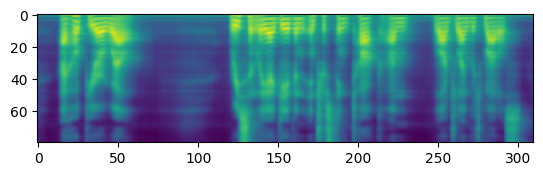

In [113]:
plt.figure()
plt.imshow(spectrogram.T)
plt.show()

Finally, use the vocoder to turn the spectrogram into sound.

In [114]:
with torch.no_grad():
    speech = vocoder(spectrogram)

In [115]:
from IPython.display import Audio
Audio(speech.numpy(), rate=16000)